**линейный классификатор** 

Евгений Борисов  <esborisov@sevsu.ru>

In [1]:
import numpy as np
from numpy import random as rng

import matplotlib.pyplot as plt

In [2]:
%precision 3
np.set_printoptions(precision=2)

# генерируем данные

In [3]:
from sklearn.datasets import make_moons
X,target = make_moons(n_samples=1024, noise=.09)

In [4]:
# from sklearn.datasets import make_blobs
# X,target = make_blobs( n_samples=1024, centers=2,  cluster_std=[1.5, 1.8,] )

In [5]:
target = (2*target-1).reshape(-1,1)
display(X.shape, target.shape)

(1024, 2)

(1024, 1)

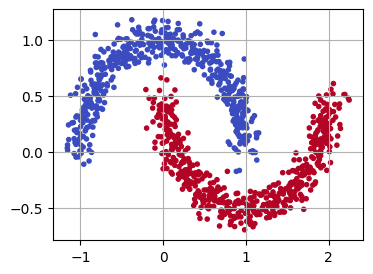

In [6]:
fig,ax = plt.subplots( figsize=(4,3),)
ax.scatter(x=X[:,0],y=X[:,1],c=target, marker='.', cmap='coolwarm')
ax.grid()

In [7]:
# нормируем данные

# from sklearn.preprocessing import MinMaxScaler
# X = MinMaxScaler([-1.0,1.0]).fit_transform(X)

from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit(X).transform(X)

display( X.min(),np.mean(X),np.median(X),X.max() )

-1.898

0.000

0.013

2.003

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, target_train, target_test = train_test_split(X,target,test_size=.5)
display( X_train.shape, X_test.shape, )

assert len(target_train) == len(X_train)
assert len(target_test) == len(X_test)

del X,target

(512, 2)

(512, 2)

# модель

$$a(x,w) = sign \left( \sum\limits_{i=1} x_i \cdot w_i + w_0 \right) $$ 

In [9]:
class LinearClassifier:
    
    def __init__( self, weight=np.array([]) ):
        self._weight = weight
    
    def score(self,x):
        assert len(x)>0
        assert x.shape[1]==len(self._weight)
        return x.dot(self._weight)
    
    def predict(self,x): 
        return np.sign( self.score(x) ).astype(np.int8)
    
    @property
    def weight(self): return self._weight

    @weight.setter
    def weight(self,value): self._weight = value
        
    def weight_init(self,n,scale=1e-7): 
        self._weight = rng.normal(size=(n,1),scale=scale)
        return self
   
    def score_partial(self,x): # частные производные модели по её параметрам
        return x

In [10]:
# LinearClassifier( weight=rng.rand(X_train.shape[1],1) ).score(X_train)
# LinearClassifier( weight=rng.rand(X_train.shape[1],1) ).predict(X_train)

# обучаем модель

отступ (margin) показывает насколько далеко объект $x$ от разделяющей поверхности

$$
M(x,y;w)= y\cdot \left( \sum\limits_{i=1} x_i \cdot w_i + w_0 \right) 
$$

функция потери

$$ L = \log \left( 1 + \exp(-M) \right) $$

$$ \nabla L = - \frac{1}{1+\exp(-M)} $$

In [11]:
class LogLoss:

    @classmethod
    def score(cls,target,predicted): 
        return np.log( 1 + np.exp( - cls._margin(target,predicted) ) ).mean()
    
    @staticmethod
    def _margin(target,predicted): return target*predicted
    
    @staticmethod
    def partial( target, predicted, model_partial, ): # градиент функции потери
        margin = target*predicted
        dl = -1./( np.exp( -margin )+1 )
        g = model_partial.T.dot( target*dl )
        g /= np.abs(g).max() # нормируем градиент
        return g

In [12]:
# model =  LinearClassifier( weight=rng.rand(X_train.shape[1],1) )
# s = model.score(X_train)
# p = model.score_partial(X_train)
# LogLoss().partial(target_train,s,p)

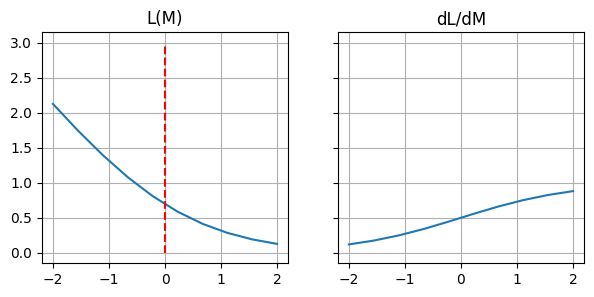

In [13]:
def loss(x): return np.log( 1 + np.exp(-x) )
def dloss(x): return 1./( 1 + np.exp(-x) )
m = np.linspace(-2,2,10)
fig,ax = plt.subplots(ncols=2,figsize=(7,3),sharey=True)
ax[0].plot(m,loss(m))
ax[0].plot([0,0],[0,3],linestyle='dashed',c='r')
ax[0].set_title('L(M)')
ax[0].grid()
ax[1].plot(m,dloss(m),)
ax[1].set_title('dL/dM')
ax[1].grid()

In [14]:
from sklearn.metrics import accuracy_score

In [15]:
from tqdm.auto import tqdm

In [16]:
class TrainGD:
    
    def __init__(self,model,loss):
        self._model = model
        self._loss = loss   
        self._lr = .1     
       
    def fit( self, X, target, lr=1e-2, n_epoch=512, acc_min=.99, ): 
        # n_epoch - максимальное число циклов обучения
        # acc_min - порог минимально допустимой погрешности модели
        self._lr = lr   # скорость обучения

        n_param = X.shape[1] # размер вектора признаков

        # инициализация параметров модели
        self._model.weight_init(n_param)

        # начальное значение ф-ции потери
        loss_history = [ self._loss.score(target,self._model.score(X)) ]
        acc_history = [ accuracy_score(target,self._model.predict(X)) ]

        for i in tqdm(range(n_epoch)): # цикл обучения
            self._fit_epoch(X,target) # корректируем веса модели
            loss_history.append(  self._loss.score(target,self._model.score(X)) ) # считаем значение ф-ции потери
            acc_history.append( accuracy_score(target,self._model.predict(X)) )

            if acc_history[-1] > acc_min: # проверяем достижение минимального порога погрешности модели
                acc = acc_history[-1]
                print(f'step {i+1}/{n_epoch}: acc {acc:.3f}, threshold {acc_min:.3f} reached\n')  
                break
                
        return (acc_history,loss_history), self._model
    
    @property
    def model(self): return self._model
    
    def _fit_epoch(self,X,target):
        # градиент функции потери, изменение весов
        g = self._loss.partial(target,self._model.score(X),self._model.score_partial(X) ) 
        self._weight_adjust(g) # корректируем параметры    
        return self
        
    def _weight_adjust(self,g):
        self._model.weight = self._model.weight - self._lr*g   # корректируем параметры
        return self
        

In [17]:
from sklearn.preprocessing import PolynomialFeatures

# собираем полином, добавляем столбец из единиц (свободный член)
poly = PolynomialFeatures( degree=1, interaction_only=False, include_bias=True,).fit(X_train)
# poly.transform(X_train)

In [18]:
(acc_history,loss_history), model = TrainGD(
        model=LinearClassifier(),
        loss=LogLoss()
    ).fit( 
        poly.transform(X_train),
        target_train,
        n_epoch=512,
        lr=1e-2,
    )

  0%|          | 0/512 [00:00<?, ?it/s]

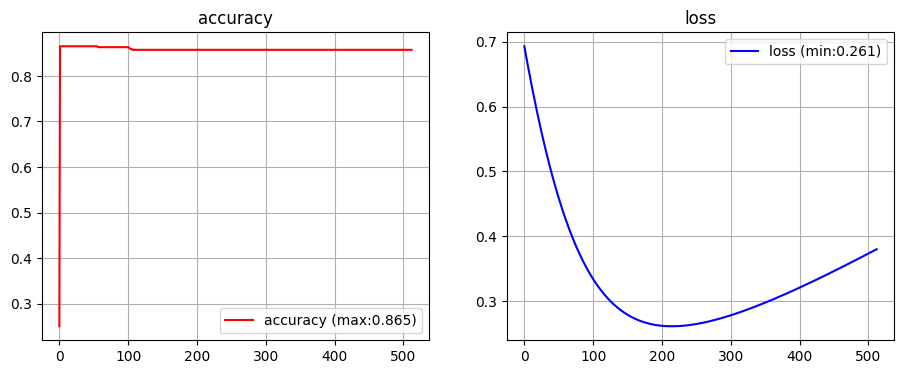

In [19]:
# история изменения значений погрешности модели
fig,ax = plt.subplots(ncols=2,figsize=(11,4))
ax[0].plot(acc_history,label=f'accuracy (max:{max(acc_history):.3f})',c='r' )
ax[0].grid()
ax[0].set_title('accuracy')
ax[0].legend()
ax[1].plot(loss_history,label=f'loss (min:{min(loss_history):.3f})',c='b' )
ax[1].grid()
ax[1].set_title('loss')
ax[1].legend()

## тестируем модель

In [20]:
from sklearn.metrics import classification_report

predicted =  model.predict(poly.transform(X_test))
print(classification_report( target_test, predicted) )

              precision    recall  f1-score   support

          -1       0.87      0.84      0.86       267
           1       0.83      0.87      0.85       245

    accuracy                           0.85       512
   macro avg       0.85      0.85      0.85       512
weighted avg       0.85      0.85      0.85       512



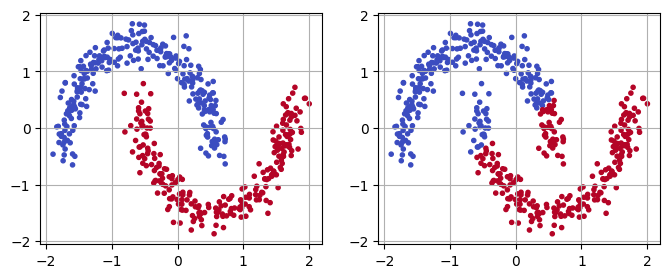

In [21]:
fig,ax = plt.subplots(1,2, figsize=(8,3),)
ax[0].scatter(x=X_test[:,0],y=X_test[:,1],c=target_test, marker='.', cmap='coolwarm')
ax[0].grid()
ax[1].scatter(x=X_test[:,0],y=X_test[:,1],c=predicted, marker='.', cmap='coolwarm')
ax[1].grid()

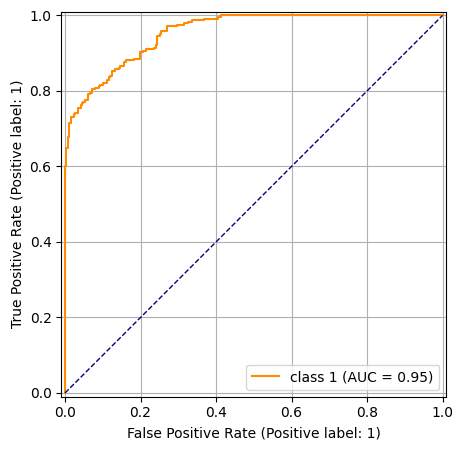

In [22]:
from sklearn.metrics import RocCurveDisplay

score = model.score(poly.transform(X_test))

fig,ax = plt.subplots( figsize=(6,5),)
RocCurveDisplay.from_predictions( target_test, score, name='class 1', color='darkorange', ax=ax )
ax.plot([0,1],[0,1], color='navy', lw=1, linestyle='--')
ax.grid()

## карта скоров

In [23]:
# строим сетку 

n = 50 # количество разбиений сетки

xx,yy = np.meshgrid(
    np.linspace( X_test[:,0].min()-0.1, X_test[:,0].max()+0.1, n), 
    np.linspace( X_test[:,1].min()-0.1, X_test[:,1].max()+0.1, n)
) # узлы сетки
display( ( xx.shape, yy.shape ) )

xy = np.vstack([xx.ravel(),yy.ravel() ]).T # разворачиваем сетку 
display( xy.shape )

# plt.figure(figsize=(7,7))
# plt.scatter( x=xy[:,0], y=xy[:,1], s=1 )
# plt.show()

((50, 50), (50, 50))

(2500, 2)

In [24]:
from sklearn.preprocessing import MinMaxScaler

# вычисляем скор для каждого узла сетки
score_xy = model.score(poly.transform(xy))
score_xy = MinMaxScaler(feature_range=(0.,1.)).fit_transform( score_xy )
score_xy = score_xy.reshape(n,n) 

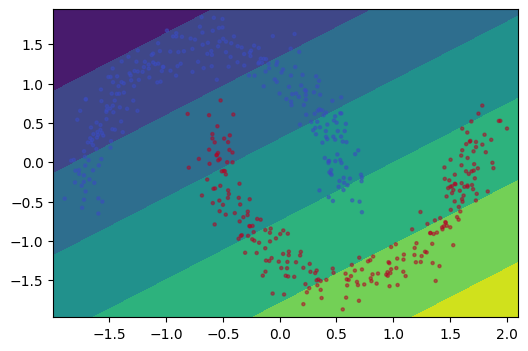

In [25]:
from matplotlib.colors import ListedColormap
fig,ax = plt.subplots(figsize=(6,4),sharey=True)
ax.contourf(xx, yy, score_xy )
ax.scatter( x=X_test[:,0], y=X_test[:,1], c=target_test, alpha=.5, s=5,  cmap='coolwarm' )
#ax[0].grid()

In [26]:
# вычисляем скор для каждого узла сетки
predict_xy = model.predict(poly.transform(xy)).reshape(n,n) 

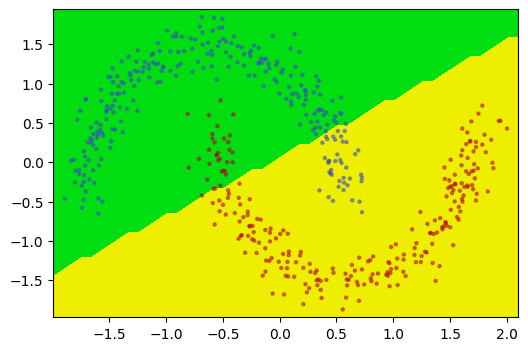

In [27]:
fig,ax = plt.subplots(figsize=(6,4),sharey=True)
ax.contourf(xx, yy, predict_xy, cmap=ListedColormap(['#0d1','#ee0']) )
ax.scatter( x=X_test[:,0], y=X_test[:,1], c=target_test, alpha=.5, s=5,  cmap='coolwarm' )